# faiss index

# imports

In [34]:
import os
import sys
import glob
import cv2
import faiss
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("../../")
%run ../../ds/unity/npz/gen.py
%run ../../ac/visualizer/plotter.py
%run ../../ds/everyeye/npz/gen_cluster.py

# prepare indexer

In [2]:
RANDOM_SEED = np.random.seed(860515)

num_dimension = 38*60      # [d] 이미지 차원 38 x 60 px
num_subquants = 95         # [M]
num_bits = 8               # [n_bits] 
num_database = 1000000     # real 이미지 개수
num_list = 100             # 작으면 정확도가 높고 속도 느림

assert num_dimension % num_subquants == 0, '인덱스 매개변수 조건 확인!'
assert num_bits in [8, 12, 16]

In [3]:
# quantizer = faiss.IndexFlatL2(num_dimension)
quantizer = faiss.IndexFlatIP(num_dimension)
index_pq = faiss.IndexIVFPQ(quantizer, num_dimension, num_list, num_subquants, num_bits)
# index_pq = faiss.IndexPQ(num_dimension, num_subquants, num_bits)

# prepare dataset (every-eye)

In [35]:
eec_path = "/home/chy/archive-data/processed/every-eye/"
ecg = EveryEyeClusterGenerator(eec_path, batch_size=10000)

*** meta verify complete [Unity-Eye-Dummy] ***


In [42]:
xb = np.empty((0, 38*60), dtype=np.float32)
for i in range(10):
    x = ecg[i]
    xb = np.concatenate([xb, x])

# prepare dataset for query (unity)

In [16]:
unity_path = "/home/chy/archive-data/processed/unity-npz"
ugen = UnityGenerator(unity_path, purpose=Purpose.ALL, for_cluster=True)

*** meta verify complete [unity-680-480] ***


# check dataset (vis)

In [38]:
real_sample = ecg[0][0]
synt_sample = ugen[0][0][0]

(2280,) (2280,)
float32 float32


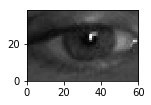

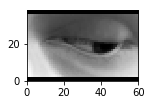

In [43]:
print(real_sample.shape, synt_sample.shape)
print(real_sample.dtype, synt_sample.dtype)
show_image(real_sample.reshape((38, 60)), fig_size=(2,2))
show_image(synt_sample.reshape((38, 60)), fig_size=(2,2))

In [ ]:
real_sample.mean

# Index train and query

### train

In [44]:
print("start index train")
index_pq.train(xb)     # 처음 10만개만 학습
print("done index train")

index train


## dataset to index

In [45]:
for x in ecg:
    index_pq.add(x)

## load & save index

In [46]:
faiss.write_index(index_pq, './every-eye-cluster-flat-ip.idx')
index_pq = faiss.read_index('./every-eye-cluster-flat-ip.idx')

## query

In [47]:
x, y = ugen[0]

In [52]:
query_imgs = x[:10]

In [53]:
D, I = index_pq.search(query_imgs, 2)

***************


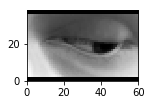

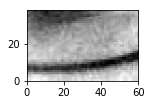

***************
***************


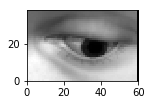

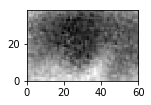

***************
***************


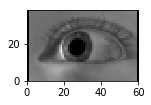

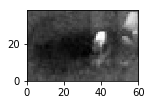

***************
***************


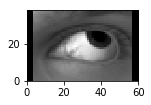

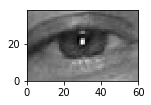

***************
***************


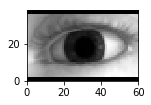

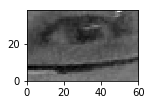

***************
***************


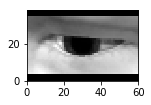

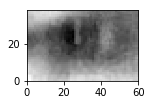

***************
***************


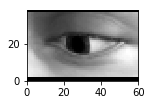

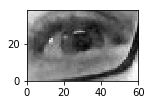

***************
***************


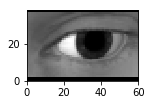

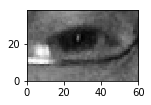

***************
***************


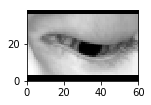

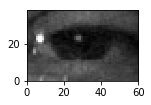

***************
***************


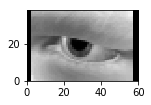

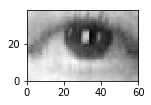

***************


In [57]:
for i, item_ids in enumerate(I):
    mark_img = ecg.item_by_index(item_ids[0])
    query_img = query_imgs[i].reshape((38, 60))
    mark_img = mark_img.reshape((38, 60))
    
    print("\n")
    show_image(query_img, fig_size=(2,2))
    show_image(mark_img, fig_size=(2,2))